# Vent opening probability

This notebook and associated files fully reproduce the vent opening probabilties for potential pumice cone vents around Aluto volcano, from the paper Clarke et al. (in prep). The script takes a grid of points, (UTM coordinates in the file 'vent_loc.csv'), and assigns to each a probability of vent opening given an eruption, based on the distribution and location of existing vents at Aluto volcano (UTM coordinates in the file 'aluto_vents.csv'). The methodology was developed by Connor and Hill (1995). The script is not necessarily specific to Aluto, and could be used provided the input point locations are provided in the correct format (inspect .csv for this). NB. the coordinates must be in a meter (such as UTM), rather than degree (such as decimal degree) format, and form a regular grid.

This Notebook requires the files:

- vent_loc.csv <-- UTM coordinate grid of potential vent locations to investigate. Provided in 'source_files' folder 
- aluto_vents.csv <-- UTM coordinates of exisitng vents at Aluto. Provided in 'source_files' folder

### Features

What the script does:
1. Imports a grid of user-specified points over which to evaluate vent opening probability
2. Imports the location of exisitng volcanic vents
3. The probability of vent opening is calculated by assuming that there is a characteristic spacing of volcanic vents at the volcano, which can be described by a Gaussian kernel with a particular bandwidth. This bandwidth is calculated by fitting a Gaussian CDF to the cumulative nearest neighbour distances of the existing volcanic vents
4. This bandwidth parameterises a Gaussian Kernel centred on every existing vent at the volcano
5. The probability of vent opening at each point on the user specified grid is calculated based on its proximity to every existing vent (see equation in next section)
6. Exports the data as a .csv, where each point in the user-defined grid of potential vent locations has an associated probabilty. This file can be imported into GIS software such as QGIS

### Mathematical Basis

The spatial intensity of volcanism at any one point (in other words, the probability of vent opening at that point given a volcanic eruption) ($\hat{\lambda}_s(x,y)$), is given by the following equation:

\begin{equation}
    \hat{\lambda}_s(x,y) = \frac{1}{2 \pi N h^2} \sum\limits_{i=1}^N 
    \exp\left(-\frac{1}{2}\left[ \frac{d_i}{h} \right]^2\right) 
\end{equation}

where $N$ is the total number of existing vents, $h$ is the bandwidth of the kernel, and $d_i$ is the distance between existing vent $i$ and point $(x,y)$.

For a more in depth explanation of this methodology see:
<p>
    
Connor and Hill (1995) Three nonhomogeneous Poisson models for the probability of basaltic volcanism: Application to the Yucca Mountain region, Nevada. *Journal of Geophysical Research* . 100: 107-117

<p>
    
Weller et al. (2006) Modelling the spatial distribution of volcanoes: an example from Armenia. *In: Statistics in Volcanology* Geological Scoiety Special Publications Vol. 1: 77-87

### Notebook Author
Ben Clarke <br /> 
https://github.com/GeoBen93 <br /> 
https://www.researchgate.net/profile/Ben_Clarke6 <br /> 
https://twitter.com/PyroclasticBen

In [10]:
#-----------------Import packages

import matplotlib.pyplot as plt
import csv
import numpy as np
from scipy.special import erf
import matplotlib.mlab as mlab
import pandas as pd
from scipy.optimize import curve_fit

## Step 1 - Import the data

In [11]:
#-----------------Import data as CSVs

vent = pd.read_csv('source_files/aluto_vents.csv')# existing vent locations
grid = pd.read_csv('source_files/vent_loc.csv')# grid of points to be evaluated

## Step 2 - Calculate the nearest neighbour distances of vents

In [12]:
x_mv1 = vent.x_mv.values # set x location values from vent csv
y_mv1 = vent.y_mv.values # set y location values from vent csv

x_mv2 = x_mv1 # create copy of x values
y_mv2 = y_mv1 # create copy of y values

#create empty fields for dx and dy
dx=[] 
dy=[]

#calculate difference in x and y coordinates between every vent. Append these to lists.
for i in range(0,len(vent)):
    for j in range(0,len(vent)):
        dx.append(np.abs(x_mv1[i] - x_mv2[j]))
        dy.append(np.abs(y_mv1[i] - y_mv2[j]))

dist = np.hypot(dx,dy) # calculate distance between vents
by_vent = np.reshape(dist,(len(vent),-1)) # split union of vent distances into distances on a vent-wise basis
m_by_vent = np.ma.masked_equal(by_vent, 0.0, copy=False) # mask zero values in array, removing the distances between vents and themselves
near = np.amin(m_by_vent, axis=1) # extract nearest (minimum) distance within each by_vent
nearkm = near*0.001 # convert to km

## Step 3 - Find best-fit Gaussian bandwidth based on nearest neighbours of vents

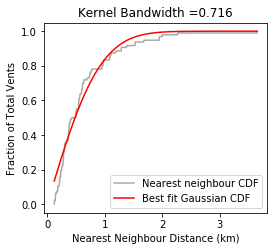

In [13]:
#----------Define function that describes best-fit CDF to the empirical nearest neighbour CDF 

def func_gauss(kernel,band):
    return erf(kernel/(np.sqrt(2)*band))

#----------Calculate cumulative density distribution of distance to nearest neighbour vent and find best fit-curve

freq = np.histogram(nearkm,bins=1000) # bin near distance data
cum_freq = np.cumsum(freq[0]) # calculate cumulative frequency of near distance bins
cum_frac = cum_freq/max(cum_freq) # calculate cumulative frequency as fraction of total vents
cum_frac = np.insert(cum_frac,0,0) # add zero value to beggining of cum_frac array to account for binning
               
xdata = freq[1] # define x data
ydata = cum_frac # define y data
               
popt, pcov = curve_fit(func_gauss, xdata, ydata) # find the function that best matches the empirical cumulative density distribution

#----------Plot result

fig = plt.figure('Kernel Bandwidth', figsize = (4,3.5))

ax1 = fig.add_subplot(111)

ax1.plot(xdata,ydata, color='darkgray', label='Nearest neighbour CDF')
ax1.plot(xdata, func_gauss(xdata, *popt), 'r-', label='Best fit Gaussian CDF')
ax1.set_xlabel("Nearest Neighbour Distance (km)")
ax1.set_ylabel("Fraction of Total Vents")
ax1.legend(loc='lower right')
bandwidth_label = 'Kernel Bandwidth =' + str(round(popt[0],3))
ax1.set_title(bandwidth_label)
plt.show()

## Step 4 - Calculate vent opening probability at user-defined grid points

This is where the equation at the top of the page comes in, now that we have the characteristic bandwidth $h$, we can plug the rest of the numbers into the equation. We repeat this for every one of the user defined grid points. 

The results of this process are saved as 'vent_opening_probabilities' in the 'notebook_output_files' folder. This is used in the 'importance_sampling_notebook', to weight the importance of simulations from each vent.

NB. This step requires the grid spacing to be defined (meters). Assinged to variable 'spacing_m'.

In [17]:
spacing_m = 500

#------------Extract x and y coordinates from near and input CSVs

x_mf = grid.x_mf.values
x_mv = vent.x_mv.values

y_mf = grid.y_mf.values
y_mv = vent.y_mv.values

#------------create empty lists for dx and dy
dx=[] 
dy=[]

#------------calculate distance between every grid point and existing vent. Append these to lists.
for i in range(0,len(x_mf)):
    for j in range(0,len(x_mv)):
        dx.append(np.abs(x_mf[i] - x_mv[j]))
        dy.append(np.abs(y_mf[i] - y_mv[j]))

dist = np.hypot(dx,dy) # calculate distance between input and near features
neardist = dist*0.001 # convert to km

#------------calculate vent opening probability at every input feature (fishnet point)

h = popt # set fixed bandwidth as Gaussian best-fit kernel bandwidth estimated in previous step
z = np.exp(-0.5*(neardist/h)**2) # calculate z for every grid-vent distance
by_grid = np.reshape(z,(len(fishnet),-1)) # split list of z values into chunks where each chunk contains all z values associated with each grid point
sumz = np.sum(by_grid, axis = 1) # sum z values in each chunk.
intensity = (sumz*(1/(2*np.pi*len(vent)*h**2))) # calculate spatial intensity at every grid point
intensity = intensity/((1000/spacing_m)**2) # because each grid point actually represents an area, we need to recalculate the intensity based on the grid spacing

Now lets have a look at the results:

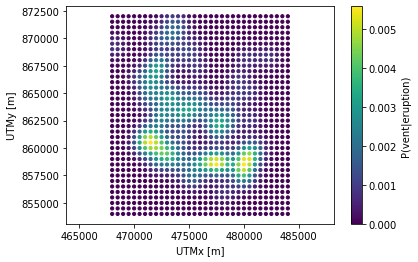

...................
Probability of opening within this grid:  0.99466
Residual probability:  0.00534


In [18]:
plt.scatter(x_mf, y_mf, c=intensity, cmap='viridis', s=10, marker='o')
plt.axis('equal')
plt.colorbar(label='P(vent|eruption)')
plt.xlabel('UTMx [m]')
plt.ylabel('UTMy [m]')
plt.ticklabel_format(axis='both', style='sci')

plt.show()

print('...................')
print('Probability of opening within this grid: ', round(sum(intensity),5))
print('Residual probability: ', round(1-sum(intensity),5))

And now let's save the results to a .csv called 'vent_opening_probabilities', into the 'notebook_output_files' folder.

In [ ]:
#------------Export data as CSV
d = {'xUTM' :x_mf, 'yUTM' :y_mf, 'Prob' :intensity}
df_prob = pd.DataFrame(d)
df_prob.to_csv('notebook_output_files/vent_opening_probabilities.csv')

#-----------Report
print('Result Saved')